In [1]:
import os
import subprocess

# For processing
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For data split and imbalanced data
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn import preprocessing

# For Random Forest testing
import h2o

# For config parsing
import configparser
config = configparser.ConfigParser()
config.read_file(open('config/config-azure.ini'))

client_attributes_file_path = config['data-files']['clients_attributes']
active_promos_file_path = config['data-files']['active_promos']
executed_promos_file_path = config['data-files']['executed_promos']
sales_file_path = config['data-files']['sales']


In [2]:
sales = pd.read_csv(sales_file_path, encoding='latin-1')
sales

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0


In [3]:
executed_promos = pd.read_csv(executed_promos_file_path, encoding='latin-1')
sanitized_executed_promos = executed_promos.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
sanitized_executed_promos

,CodigoDC,Cliente,Marca,Cupo
0,297601,8410,29,9
1,297601,9337,29,9
2,309843,7404,40,16
3,309874,4017,40,16
4,309910,6316,40,16
...,...,...,...,...
27763,646815,2144,29,9
27764,646976,28,29,9
27765,647188,10023,29,9
27766,648099,10193,29,9


In [4]:
active_promos = pd.read_csv(active_promos_file_path, encoding='latin-1')

In [5]:
clients_attributes = pd.read_csv(client_attributes_file_path, encoding='latin-1')
clients_attributes

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,2009-03-03,4,21,12,1,1,1
1,9,2009-03-03,4,21,9,2,3,1
2,15,2009-03-03,4,21,9,2,3,0
3,37,2009-03-03,4,21,16,2,3,1
4,43,2009-03-03,4,21,9,2,3,0
...,...,...,...,...,...,...,...,...
15064,15040,2019-03-07,1,16,9,2,1,0
15065,15043,2019-03-07,1,20,15,2,2,1
15066,15052,2019-03-09,3,7,10,2,2,0
15067,15065,2019-03-16,4,21,9,2,2,0


In [6]:
sales_exec_promos = sales.merge(sanitized_executed_promos, how = 'left', on = ['Cliente', 'Marca', 'Cupo'])
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == False, 'ES_PROMO'] = 'SI'

sales_exec_promos

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,CodigoDC,ES_PROMO
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0,NaN,NaN
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0,NaN,NaN
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0,NaN,NaN
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0,NaN,NaN
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0,NaN,NaN
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NaN
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NaN
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0,NaN,NaN


In [7]:
df = sales_exec_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
final_df = df[['Cliente', 'Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF','ES_PROMO']].fillna({
    'ES_PROMO': 'NO',
    'Cupo': df['Cupo'].mode()[0]
})

final_df

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,NO
1,1,18,16.0,4,21,12,1,1,1,NO
2,1,2,6.0,4,21,12,1,1,1,NO
3,1,37,34.0,4,21,12,1,1,1,NO
4,1,2,16.0,4,21,12,1,1,1,NO
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,44,32.0,1,5,9,2,3,1,NO
1894248,15069,44,32.0,4,14,9,2,1,0,NO
1894249,15069,44,32.0,4,14,9,2,1,0,NO
1894250,15069,2,6.0,4,14,9,2,1,0,NO


### Preparar Data de Test y Train

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /anaconda/envs/py37_default/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfpfbzmle
  JVM stdout: /tmp/tmpfpfbzmle/h2o_tjander_started_from_python.out
  JVM stderr: /tmp/tmpfpfbzmle/h2o_tjander_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_tjander_3lztmn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


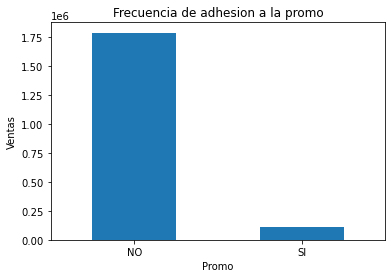

In [8]:
h2o.init(nthreads = -1, max_mem_size = '16g')

trgt_index = final_df.columns.tolist().index('ES_PROMO')

x_to_split, y_to_split = final_df.iloc[:, 0:trgt_index].values, final_df.iloc[:, trgt_index].values

x_train_st, x_test, y_train_st, y_test = train_test_split(x_to_split,
                                                    y_to_split)

count_class = pd.value_counts(final_df['ES_PROMO'], sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()



/anaconda/envs/py37_default/lib/python3.7/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


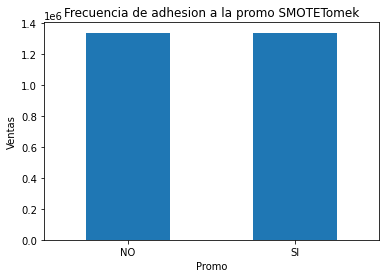

In [9]:
os_us = SMOTETomek(1)
x_train, y_train = os_us.fit_sample(x_train_st, y_train_st)

count_class = pd.value_counts(y_train, sort = True)
count_class.plot(kind = 'bar', rot = 0)
plt.title('Frecuencia de adhesion a la promo SMOTETomek')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [10]:
cols = final_df.columns.tolist()
del cols[trgt_index]
x_train_df, y_train_df = pd.DataFrame(x_train, columns = cols), pd.DataFrame(y_train, columns = ['ES_PROMO'])
df_train = pd.concat([x_train_df, y_train_df], axis = 1)
df_train

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,7246.0,44.0,32.0,4.0,26.0,9.0,2.0,2.0,0.0,NO
1,2203.0,37.0,34.0,3.0,25.0,10.0,1.0,1.0,1.0,NO
2,2180.0,44.0,16.0,3.0,25.0,22.0,1.0,2.0,0.0,NO
3,10468.0,44.0,31.0,4.0,13.0,9.0,1.0,1.0,1.0,NO
4,8732.0,40.0,16.0,5.0,31.0,16.0,1.0,1.0,1.0,SI
...,...,...,...,...,...,...,...,...,...,...
2677141,11292.0,40.0,16.0,3.0,7.0,15.0,2.0,3.0,1.0,SI
2677142,12291.0,40.0,16.0,3.0,8.0,9.0,2.0,2.0,0.0,SI
2677143,4615.0,40.0,16.0,5.0,11.0,15.0,2.0,2.0,0.0,SI
2677144,3513.0,40.0,16.0,3.0,30.0,15.0,1.0,2.0,1.0,SI


In [11]:
x_test_df, y_test_df = pd.DataFrame(x_test, columns = cols), pd.DataFrame(y_test, columns = ['ES_PROMO'])
df_test = pd.concat([x_test_df, y_test_df], axis = 1)

In [12]:
h2o_train = h2o.H2OFrame(df_train)
h2o_test  = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
m = h2o.estimators.H2ODeepLearningEstimator(
                        activation="TanhWithDropout", 
                        hidden=[8, 8],
                        epochs=1000)

In [33]:
predictor_cols = ['Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF']
target_col     = 'ES_PROMO'
m.train(training_frame = h2o_train,
        x = predictor_cols,
        y = target_col)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


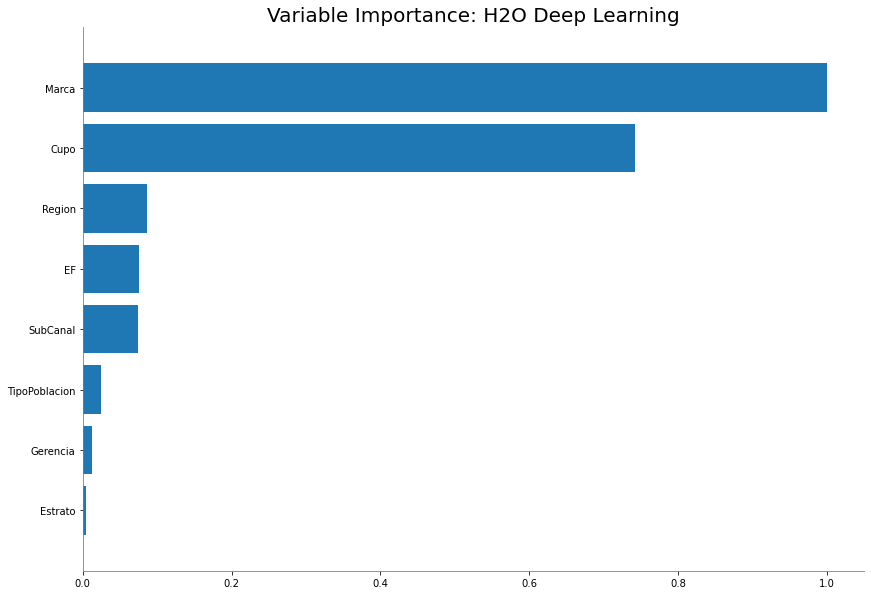

In [34]:
m.varimp_plot()

In [35]:
m.model_performance(h2o_test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2760126469114935
RMSE: 0.5253690578169726
LogLoss: 0.7808114715320618
Mean Per-Class Error: 0.18737723004063178
AUC: 0.8126227699593682
AUCPR: 0.1417699287735389
Gini: 0.6252455399187364

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8747163809412655: 


,,NO,SI,Error,Rate
0,NO,278832.0,167124.0,0.3748,(167124.0/445956.0)
1,SI,0.0,27607.0,0.0,(0.0/27607.0)
2,Total,278832.0,194731.0,0.3529,(167124.0/473563.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.874716,0.248334,0.0
1,max f2,0.874716,0.452338,0.0
2,max f0point5,0.874716,0.171147,0.0
3,max accuracy,0.874716,0.647092,0.0
4,max precision,0.874716,0.141770,0.0
5,max recall,0.874716,1.000000,0.0
6,max specificity,0.874716,0.625246,0.0
7,max absolute_mcc,0.874716,0.297726,0.0
8,max min_per_class_accuracy,0.874716,0.625246,0.0
9,max mean_per_class_accuracy,0.874716,0.812623,0.0



Gains/Lift Table: Avg response rate:  5.83 %, avg score: 39.59 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.411204,0.874716,2.431883,2.431883,0.14177,0.874716,0.141770,0.874716,1.0,1.0,143.188296,143.188296,0.625246
1,2,1.000000,0.051377,0.000000,1.000000,0.00000,0.061420,0.058296,0.395851,0.0,1.0,-100.000000,0.000000,0.000000


In [36]:
cli_active_promo = active_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
columns = final_df.columns.tolist()
index_target = columns.index('ES_PROMO')
del columns[index_target]

cli_active_promo = cli_active_promo[columns]
cli_active_promo.head(1)


h2o_predict_df = h2o.H2OFrame(cli_active_promo)

p = m.predict(h2o_predict_df)
p

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,NO,SI
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716
SI,0.125284,0.874716


### Sanitizar output

In [37]:
predicted_df = h2o.as_list(p)
predicted_df = predicted_df.rename(columns = {'SI': 'Ejecuto_Promo'})

pred_merged_df = pd.concat([active_promos,predicted_df],axis=1)

# resultado_final
pred_no_dupes_df = pred_merged_df.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
pred_no_dupes_df
result = pred_no_dupes_df[['Cliente', 'Marca', 'Cupo', 'Ejecuto_Promo']].set_index('Cliente')
result


,Marca,Cupo,Ejecuto_Promo
Cliente,,,
3213,29,9,0.874716
3795,29,9,0.874716
11816,29,9,0.874716
8444,40,16,0.874716
8488,40,16,0.874716
...,...,...,...
15040,39,20,0.874716
14840,40,16,0.874716
1844,29,9,0.874716


In [38]:
import tempfile
output_filename = "{}/{}".format(tempfile.gettempdir(), "neural_network.csv")

print("GUARDANDO EL OUTPUT EN {} ...".format(output_filename))
result
result.to_csv(output_filename)

GUARDANDO EL OUTPUT EN /tmp/neural_network.csv ...
